# Chess result prediction - Classification

---

Based on https://www.kaggle.com/datasnaek/chess dataset with 20000 games, we'd like to predict the outcome of the game.
However, the draws events are around 900 therefore, the dataset is very imbalanced.
We will therefore consider as well 900 white and black wins to model.
More data would be welcome to improve the results of the model.

Features we have are:

- Game ID;
- Rated (T/F);
- Start Time;
- End Time;
- Number of Turns;
- Game Status;
- Winner;
- Time Increment;
- White Player ID;
- White Player Rating;
- Black Player ID;
- Black Player Rating;
- All Moves in Standard Chess Notation;
- Opening Eco (Standardised Code for any given opening, list here);
- Opening Name;
- Opening Ply (Number of moves in the opening phase)

---

In [1]:
# Loading packages and used methods

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

In [2]:
# Loading data and first overview
fileName = 'games.csv'

def firstAnalysis(fileName):
    df = pd.read_csv(fileName)
    print('*************************************************************************')
    print('*************************************************************************')
    print(df.dtypes); print(); print('*************************************************************************')
    n,m = df.shape
    print(n,m); print('*************************************************************************')
    print(df.isna().sum()); print(); print('*************************************************************************')
    print('*************************************************************************')
    return(df)

df = firstAnalysis(fileName)
df.head()

*************************************************************************
*************************************************************************
id                 object
rated                bool
created_at        float64
last_move_at      float64
turns               int64
victory_status     object
winner             object
increment_code     object
white_id           object
white_rating        int64
black_id           object
black_rating        int64
moves              object
opening_eco        object
opening_name       object
opening_ply         int64
dtype: object

*************************************************************************
20058 16
*************************************************************************
id                0
rated             0
created_at        0
last_move_at      0
turns             0
victory_status    0
winner            0
increment_code    0
white_id          0
white_rating      0
black_id          0
black_rating      0
moves             0
open

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


In [3]:
df['opening_ply'].unique()

array([ 5,  4,  3, 10,  6,  1,  9,  2,  8,  7, 17, 11, 12, 13, 18, 19, 15,
       16, 14, 28, 20, 22, 24], dtype=int64)

In [4]:
toDrop = ['id','created_at','last_move_at','opening_name','moves','white_id','black_id','victory_status']
df.drop(columns = toDrop, inplace=True)
df = df[['rated','increment_code','white_rating','black_rating','opening_eco','turns','opening_ply','winner']]
df.head()

,rated,increment_code,white_rating,black_rating,opening_eco,turns,opening_ply,winner
0,False,15+2,1500,1191,D10,13,5,white
1,True,5+10,1322,1261,B00,16,4,black
2,True,5+10,1496,1500,C20,61,3,white
3,True,20+0,1439,1454,D02,61,3,white
4,True,30+3,1523,1469,C41,95,5,white


In [5]:
df['opening_eco'].unique()

array(['D10', 'B00', 'C20', 'D02', 'C41', 'B27', 'D00', 'C50', 'B01',
       'A00', 'C02', 'C00', 'C57', 'C55', 'A40', 'B20', 'A25', 'B21',
       'D01', 'C45', 'D06', 'B52', 'D20', 'B06', 'A45', 'B77', 'A21',
       'B70', 'B23', 'B76', 'C21', 'A80', 'A20', 'A04', 'C26', 'C44',
       'E10', 'A41', 'C01', 'A10', 'C18', 'A47', 'C10', 'D80', 'D30',
       'D41', 'A46', 'D31', 'C64', 'C24', 'A43', 'A08', 'B03', 'B29',
       'B02', 'B13', 'B57', 'E20', 'E11', 'C40', 'C11', 'C28', 'B30',
       'A56', 'C65', 'B90', 'B50', 'B51', 'E00', 'C70', 'B11', 'B22',
       'B40', 'B31', 'B18', 'C61', 'C78', 'B10', 'C22', 'C54', 'C68',
       'B12', 'C77', 'A42', 'C42', 'D07', 'B32', 'A22', 'C46', 'B07',
       'A06', 'C60', 'A07', 'A02', 'C58', 'A03', 'B54', 'D03', 'C69',
       'A31', 'D46', 'C34', 'C48', 'C47', 'B24', 'C67', 'E61', 'C53',
       'C23', 'B96', 'A05', 'D92', 'A49', 'C37', 'A09', 'A01', 'C88',
       'B34', 'C03', 'C33', 'A48', 'A11', 'A81', 'B05', 'B53', 'B08',
       'C30', 'A15',

In [6]:
df['opening_eco'] = df['opening_eco'].astype(str).str[0:2]
df['opening_eco'].unique()
df['opening_eco'] = pd.Categorical(df['opening_eco'])
df['opening_eco'] = df['opening_eco'].cat.codes
df.head()

,rated,increment_code,white_rating,black_rating,opening_eco,turns,opening_ply,winner
0,False,15+2,1500,1191,31,13,5,white
1,True,5+10,1322,1261,10,16,4,black
2,True,5+10,1496,1500,22,61,3,white
3,True,20+0,1439,1454,30,61,3,white
4,True,30+3,1523,1469,24,95,5,white


In [7]:
df.head()

,rated,increment_code,white_rating,black_rating,opening_eco,turns,opening_ply,winner
0,False,15+2,1500,1191,31,13,5,white
1,True,5+10,1322,1261,10,16,4,black
2,True,5+10,1496,1500,22,61,3,white
3,True,20+0,1439,1454,30,61,3,white
4,True,30+3,1523,1469,24,95,5,white


In [8]:
df['diff_class'] = df['white_rating']-df['black_rating']

In [9]:
df.head()

,rated,increment_code,white_rating,black_rating,opening_eco,turns,opening_ply,winner,diff_class
0,False,15+2,1500,1191,31,13,5,white,309
1,True,5+10,1322,1261,10,16,4,black,61
2,True,5+10,1496,1500,22,61,3,white,-4
3,True,20+0,1439,1454,30,61,3,white,-15
4,True,30+3,1523,1469,24,95,5,white,54


In [10]:
df.head()

,rated,increment_code,white_rating,black_rating,opening_eco,turns,opening_ply,winner,diff_class
0,False,15+2,1500,1191,31,13,5,white,309
1,True,5+10,1322,1261,10,16,4,black,61
2,True,5+10,1496,1500,22,61,3,white,-4
3,True,20+0,1439,1454,30,61,3,white,-15
4,True,30+3,1523,1469,24,95,5,white,54


In [11]:
df.head()

,rated,increment_code,white_rating,black_rating,opening_eco,turns,opening_ply,winner,diff_class
0,False,15+2,1500,1191,31,13,5,white,309
1,True,5+10,1322,1261,10,16,4,black,61
2,True,5+10,1496,1500,22,61,3,white,-4
3,True,20+0,1439,1454,30,61,3,white,-15
4,True,30+3,1523,1469,24,95,5,white,54


In [12]:
mnw,mxw = df['white_rating'].min(),df['white_rating'].max()
mnb,mxb = df['black_rating'].min(),df['black_rating'].max()
print(mnw)
print(mxw)
print(mnb)
print(mxb)

784
2700
789
2723


In [13]:
df['white_rating'] = pd.cut(df['white_rating'], bins=[600, 800, 1000, 
                    1200, 1400, 1600, 1800, 2000,2200,2400,2500,2700,3000], 
                    include_lowest=True, labels=['A', 'B', 'C', 'D', 'E', 'F','G','H','I','J','K','L'])
df['white_rating'].replace({'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11}, inplace = True)

In [14]:
df['black_rating'] = pd.cut(df['black_rating'], bins=[600, 800, 1000, 
                    1200, 1400, 1600, 1800, 2000,2200,2400,2500,2700,3000], 
                    include_lowest=True, labels=['A', 'B', 'C', 'D', 'E', 'F','G','H','I','J','K','L'])
df['black_rating'].replace({'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11}, inplace = True)

In [15]:
df.head()

,rated,increment_code,white_rating,black_rating,opening_eco,turns,opening_ply,winner,diff_class
0,False,15+2,4,2,31,13,5,white,309
1,True,5+10,3,3,10,16,4,black,61
2,True,5+10,4,4,22,61,3,white,-4
3,True,20+0,4,4,30,61,3,white,-15
4,True,30+3,4,4,24,95,5,white,54


In [16]:
df = df[['rated','increment_code','white_rating','black_rating','diff_class','opening_eco','turns','opening_ply','winner']]
df.head()

,rated,increment_code,white_rating,black_rating,diff_class,opening_eco,turns,opening_ply,winner
0,False,15+2,4,2,309,31,13,5,white
1,True,5+10,3,3,61,10,16,4,black
2,True,5+10,4,4,-4,22,61,3,white
3,True,20+0,4,4,-15,30,61,3,white
4,True,30+3,4,4,54,24,95,5,white


In [17]:
df['rated'].replace({False:0,True:1}, inplace = True)

In [18]:
df.head()

,rated,increment_code,white_rating,black_rating,diff_class,opening_eco,turns,opening_ply,winner
0,0,15+2,4,2,309,31,13,5,white
1,1,5+10,3,3,61,10,16,4,black
2,1,5+10,4,4,-4,22,61,3,white
3,1,20+0,4,4,-15,30,61,3,white
4,1,30+3,4,4,54,24,95,5,white


In [19]:
df['game_type'] = df['increment_code'].astype(str).str[0:2]
df.head()

,rated,increment_code,white_rating,black_rating,diff_class,opening_eco,turns,opening_ply,winner,game_type
0,0,15+2,4,2,309,31,13,5,white,15
1,1,5+10,3,3,61,10,16,4,black,5+
2,1,5+10,4,4,-4,22,61,3,white,5+
3,1,20+0,4,4,-15,30,61,3,white,20
4,1,30+3,4,4,54,24,95,5,white,30


In [20]:
a = df.groupby(['winner','game_type']).size()

In [21]:
df['game_type'].replace({'0+':0 , '1+':1 , '2+':2 ,'3+':3, '4+':4, '5+':5,
                               '6+':6,'7+':7,'8+':8,'9+':9,'10':10,'11':11,'12':12,
                               '13':13,'14':14,'15':15,'16':16,'17':17,'18':18,'19':19,
                               '20':20,'21':21,'25':25,'29':29,'30':30,'35':35,'40':40,'45':45,
                               '60':60,'90':90},inplace=True)

In [22]:
df.head()

,rated,increment_code,white_rating,black_rating,diff_class,opening_eco,turns,opening_ply,winner,game_type
0,0,15+2,4,2,309,31,13,5,white,15
1,1,5+10,3,3,61,10,16,4,black,5
2,1,5+10,4,4,-4,22,61,3,white,5
3,1,20+0,4,4,-15,30,61,3,white,20
4,1,30+3,4,4,54,24,95,5,white,30


In [23]:
df['winner'].replace({'black':0 , 'draw':1, 'white':2},inplace=True)

In [24]:
df.head()

,rated,increment_code,white_rating,black_rating,diff_class,opening_eco,turns,opening_ply,winner,game_type
0,0,15+2,4,2,309,31,13,5,2,15
1,1,5+10,3,3,61,10,16,4,0,5
2,1,5+10,4,4,-4,22,61,3,2,5
3,1,20+0,4,4,-15,30,61,3,2,20
4,1,30+3,4,4,54,24,95,5,2,30


In [25]:
df['diff'] = df['white_rating'] - df['black_rating']

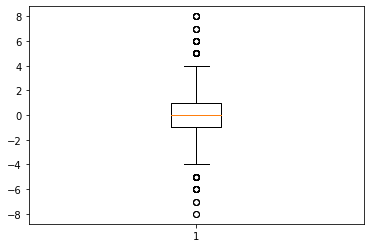

In [26]:
plt.boxplot(df['diff']);

In [27]:
print(df.shape)
df.groupby(['winner','diff']).size()

(20058, 11)


winner  diff
0       -8         2
        -7         2
        -6         9
        -5        44
        -4       119
        -3       332
        -2       933
        -1      2281
         0      3878
         1      1216
         2       214
         3        59
         4        15
         5         3
1       -4         5
        -3         8
        -2        43
        -1       193
         0       444
         1       173
         2        64
         3        12
         4         6
         5         1
         6         1
2       -7         1
        -6         1
        -5         4
        -4        13
        -3        73
        -2       249
        -1      1241
         0      4189
         1      2578
         2      1078
         3       370
         4       123
         5        54
         6        16
         7         5
         8         6
dtype: int64

In [28]:
df = df[['rated','game_type','diff','diff_class','opening_eco','turns','opening_ply','winner']]
df.head()

,rated,game_type,diff,diff_class,opening_eco,turns,opening_ply,winner
0,0,15,2,309,31,13,5,2
1,1,5,0,61,10,16,4,0
2,1,5,0,-4,22,61,3,2
3,1,20,0,-15,30,61,3,2
4,1,30,0,54,24,95,5,2


In [29]:
#ax = sns.pairplot(data = df, hue = 'winner', kind = 'scatter');

In [30]:
df.corr()

,rated,game_type,diff,diff_class,opening_eco,turns,opening_ply,winner
rated,1.000000,-0.098902,-0.028380,-0.034321,0.019837,0.090698,-0.001906,-0.006722
game_type,-0.098902,1.000000,0.017088,0.018008,-0.004997,-0.030892,0.041988,0.015375
diff,-0.028380,0.017088,1.000000,0.953920,0.024837,-0.035214,0.020926,0.339653
diff_class,-0.034321,0.018008,0.953920,1.000000,0.031269,-0.035781,0.025932,0.360669
opening_eco,0.019837,-0.004997,0.024837,0.031269,1.000000,0.029167,0.466252,0.021147
turns,0.090698,-0.030892,-0.035214,-0.035781,0.029167,1.000000,0.055999,-0.044346
opening_ply,-0.001906,0.041988,0.020926,0.025932,0.466252,0.055999,1.000000,0.020669
winner,-0.006722,0.015375,0.339653,0.360669,0.021147,-0.044346,0.020669,1.000000


In [31]:
# We drop highly correlated features
# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.97)]

# Drop features that are so much correlated, and therefore would be bringing redundant information
df.drop(to_drop, axis=1, inplace=True)

# Now we want to select main features correlated with dependent variable "winner"
# Correlation with output variable
corr_matrix = df.corr().abs()
corr_matrix_target = abs(corr_matrix["winner"])

# Selecting highly correlated features
relevant_features = corr_matrix_target[corr_matrix_target > 0.02]
relevant_features

diff           0.339653
diff_class     0.360669
opening_eco    0.021147
turns          0.044346
opening_ply    0.020669
winner         1.000000
Name: winner, dtype: float64

In [32]:
df.drop(columns = ['rated','game_type'], axis = 1, inplace = True)

In [112]:
df.to_csv('forModelingGames.csv',index=False)

In [113]:
df_chess = pd.read_csv('forModelingGames.csv')

In [114]:
df_chess.head()

,diff,diff_class,opening_eco,turns,opening_ply,winner
0,2,309,31,13,5,2
1,0,61,10,16,4,0
2,0,-4,22,61,3,2
3,0,-15,30,61,3,2
4,0,54,24,95,5,2


In [115]:
aa,bb,cc = df_chess.groupby(['winner']).size()
print(aa)
print(bb)
print(cc)

9107
950
10001


In [116]:
a = df_chess.loc[df_chess['winner'] == 0]
b = df_chess.loc[df_chess['winner'] == 1]
c = df_chess.loc[df_chess['winner'] == 2]

a = a.sample(n = bb+500)
b = b.sample(n = bb)
c = c.sample(n = bb+500)

new_chess = np.concatenate([a,b,c],axis=0)
X = new_chess[:,0:new_chess.shape[1]-1]
y = new_chess[:,new_chess.shape[1]-1]

X = StandardScaler().fit(X).transform(X)

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=True)

In [118]:
# We train the binary logistic regression model and fit
clf = LogisticRegression(multi_class = 'multinomial', solver='lbfgs').fit(X_train, y_train)

In [119]:
# Predicted values from X_test
y_hat = clf.predict(X_test)

# Metrics
acc_training = clf.score(X_train,y_train)
acc = accuracy_score(y_test, y_hat)

In [120]:
print('Training accuracy = ', acc_training)
print('Accuracy = ', acc)

Training accuracy =  0.5422077922077922
Accuracy =  0.5376623376623376


In [121]:
cm = confusion_matrix(y_test,y_hat)
cm

array([[165,  36,  80],
       [ 67,  76,  62],
       [ 87,  24, 173]], dtype=int64)

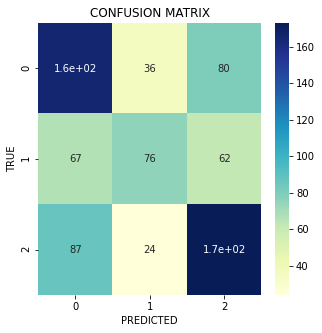

In [122]:
# printing the confusion matrix
plt.rcParams['figure.figsize'] = (5, 5)
sns.heatmap(cm, annot = True, cmap = 'YlGnBu')
plt.title('CONFUSION MATRIX', fontsize = 12)
plt.xlabel('PREDICTED')
plt.ylabel('TRUE')
plt.show()

In [123]:
prob = clf.predict_proba(X_test)

In [151]:
situation = y_test-y_hat

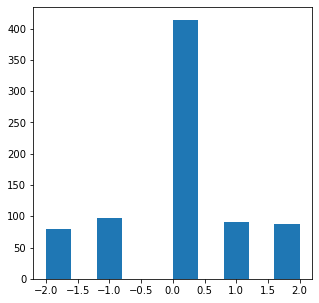

In [153]:
plt.hist(situation);